In [14]:
% load_ext autoreload
% autoreload 2

import pandas as pd
import math
import numpy as np

from matplotlib import pyplot as plt

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [ ]:
SRC_ARTICLES = '../data/guardian-all/articles-standardized.csv'
SRC_AUTHORS = '../data/guardian-all/authors-standardized.csv'

SRC_COMMENTS_POL = '../data/pol/comments-root-all-pol.csv'

SRC_GENSIM_EMBEDDING = '../data/embedding/gensim-guardian-comments-50-tokenized.bin'

# Files to generate
SRC_ENHANCED_COMMENTS = '../data/pol/comments-root-all-pol-enhanced.csv'
SRC_FILTERED_COMMENTS = '../data/pol/comments-root-all-pol-filtered.csv'

### Add attributes to the comments

In [31]:
co = pd.read_csv(SRC_COMMENTS_POL)  # 1370587 rows × 7 columns
print(f'Loaded comments with shape {co.shape}')

Loaded comments with shape (1370587, 7)


In [34]:
co[co['article_id'] == 47823]

,Unnamed: 0,article_id,author_id,comment_id,comment_text,timestamp,upvotes
190561,4915453,47823,205111,63597870,Nevermind the Northern rail upgrades we were p...,2015-11-19T18:52:03Z,1
190562,4915454,47823,216284,63597644,Listen up nerds! Your first task is to find a ...,2015-11-19T18:46:43Z,2
190563,4915455,47823,23283,63596648,The thought of all those w**ky little propello...,2015-11-19T18:24:44Z,1
190564,4915456,47823,23547,63620161,Has the DfT ever thought of asking the passeng...,2015-11-20T08:26:12Z,0
190565,4915458,47823,2608,63623906,How about an App to re-unite the National Rail...,2015-11-20T09:42:32Z,2
190566,4915460,47823,29928,63607862,Not quite sure how software developers are goi...,2015-11-19T22:50:20Z,2
190567,4915462,47823,30170,63603532,"so how will a hackathon, say, improve the legr...",2015-11-19T21:07:58Z,0
190568,4915464,47823,322138,63595294,'The first integrated smartcard scheme outside...,2015-11-19T17:56:57Z,12
190569,4915478,47823,43374,63592243,How about a paradigm shift - try running the r...,2015-11-19T16:59:46Z,32
190570,4915479,47823,43822,63602318,Just go to France or China cheap very fast rai...,2015-11-19T20:35:15Z,3


In [44]:
co[co['comment_id'] == 63592243].values

array([[4915478, 47823, 43374, 63592243,
        'How about a paradigm shift - try running the railways as an integrated whole as a public service rather than as a cashcow for private companies who have no incentive to improve service as they are monopolies',
        '2015-11-19T16:59:46Z', 32]], dtype=object)

In [42]:
co[co['comment_text'].str.contains('chopped off')]

,Unnamed: 0,article_id,author_id,comment_id,comment_text,timestamp,upvotes
156235,2770748,25844,69842,24051790,Until Scotland regained a parliament politics ...,2013-06-04T08:16:09Z,3
222843,5373780,50224,14979,35009398,"Yeah, except the Tories aren't going to win. W...",2014-04-30T11:30:23Z,6
261373,5938474,54481,34168,322980,AngloSyrian: Improving the image of the UK in ...,2010-01-08T12:10:40Z,0
261401,5938502,54481,347402,322550,CanWeNotKnockIt Improving the image of the UK...,2010-01-08T12:03:05Z,0
266899,6652438,61126,9804,1378786,I cant bring myself to agree with the ghastly ...,2009-02-18T09:39:28Z,0
304438,13220993,124154,3752,10809116,chingwu: rape is AS BAD AS IT GETS. And murder...,2011-05-18T15:09:18Z,0
506203,18994395,177812,3128,22885653,"Hey Guardian, how come Lady Lamont of strathSc...",2013-04-19T16:43:45Z,9
516415,19121489,178728,1982,14977071,Like almost everybody else in this country so ...,2012-03-04T08:52:54Z,3
535951,19323987,181289,39977,107778142,Perhaps make the bikes property of the Queen s...,2017-11-05T07:52:33Z,3
540041,20159574,187716,39823,64319733,There are none so blind as those who will nor ...,2015-12-01T15:42:20Z,3


In [24]:
article = pd.read_csv(SRC_ARTICLES)
# 47823

In [ ]:
article['articl']

In [30]:
article[article['article_id'] == 47823].values

array([[47823,
        'https://www.theguardian.com/politics/2015/nov/19/transport-hackathon-hacktrain-uk-railways']],
      dtype=object)

In [4]:
print('Add rank attribute')
co['rank'] = co.groupby('article_id')['timestamp'].rank(method='dense').astype(int)

print('Add article attributes')
co['total_upvotes'] = co.groupby('article_id')['upvotes'].transform('sum')
co['total_comments'] = co.groupby('article_id')['upvotes'].transform('count')

print('Apply normalization')
co['rel_upvotes'] = co.apply(lambda row: (row.upvotes / (row.total_upvotes or 1)) * 100, axis=1)

print(co.shape)
co.head()

Add rank attribute
Add article attributes
Apply normalization
(1370587, 11)


,Unnamed: 0,article_id,author_id,comment_id,comment_text,timestamp,upvotes,rank,total_upvotes,total_comments,rel_upvotes
0,133678,1486,10680,72619094,Let's go Sian!,2016-04-18T22:35:17Z,9,14,552,40,1.630435
1,133694,1486,2214,72620249,Instead of taking for media rhetoric people co...,2016-04-18T22:54:30Z,10,19,552,40,1.811594
2,133698,1486,24826,72618983,Goldsmith or probably Crosby to be more accura...,2016-04-18T22:33:24Z,21,10,552,40,3.804348
3,133700,1486,2494,72618704,The Dead Cat has made yet another appearance. ...,2016-04-18T22:28:55Z,12,7,552,40,2.173913
4,133701,1486,25059,72620243,Oh ! You lucky Londoners. You get to choose wh...,2016-04-18T22:54:25Z,6,18,552,40,1.086957


### Filter and select best comments

In [12]:
filtered = co[co['rank'] <= 10]  # select only first 10 comments
filtered = filtered[filtered['total_upvotes'] > 10] # do not consider articles with under 10 upvotes
filtered = filtered[filtered['total_comments'] >= 200] # remove articles with less than 10 comments.
# filtered = filtered[filtered['total_comments'] < 2000] # remove articles with over 200 comments.
filtered = filtered[filtered['comment_text'].str.len() > 50]
print(filtered.shape)  # 76025 rows × 11 columns

(12830, 11)


In [14]:
# We have at least 8k samples per rank -> 4k top, 4k bottom

N = 4000
# Select N comments with most (rel.) upvotes and N comments with the fewest (rel.) upvotes
res_pos = filtered.groupby("rank", group_keys=False).apply(lambda g: g.nlargest(N, "rel_upvotes"))
res_neg = filtered.groupby("rank", group_keys=False).apply(lambda g: g.nsmallest(N, "rel_upvotes"))
res_pos['bin'] = 1
res_neg['bin'] = 0

In [15]:
res = pd.concat([res_pos, res_neg])
print(res.shape)
res.to_csv(SRC_ENHANCED_COMMENTS)  # 10k per rank -> 100000 rows x 12 columns

(80000, 12)


Text(0.5,1,'Total Upvotes')

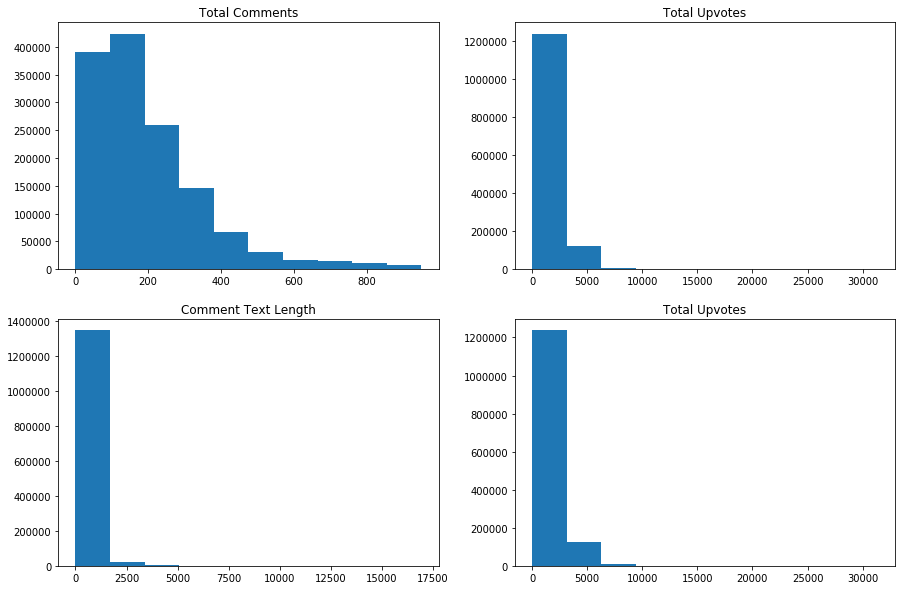

In [20]:
fig, axes = plt.subplots(2, 2, figsize=(15, 10))
axes[0, 0].hist(co['total_comments'])
axes[0, 0].set_title('Total Comments')

axes[0, 1].hist(co['total_upvotes'])
axes[0, 1].set_title('Total Upvotes')

axes[1, 0].hist(co['comment_text'].str.len())
axes[1, 0].set_title('Comment Text Length')

axes[1, 1].hist(co['total_upvotes'])
axes[1, 1].set_title('Total Upvotes')